# Résolution de la régression linéaire

On rappelle que l'on a un jeu de données avec des mesures de circonférence et de hauteur pour plusieurs arbres.

$$ \{(x_1, y_1), (x_2, y_2), ..., (x_n, y_n)\} $$

Que l'on modélise par une droite :
$$
\text{hauteur} = \text{a} \cdot \text{circonférence} + \text{b}
$$

Pour trouver la meilleure droite, on cherche à minimiser **la fonction d'erreur J**, ici on choisit la **Mean Squared Error (MSE)** qui mesure l'erreur moyenne entre les vraies valeurs yᵢ et les valeurs prédites ŷᵢ par le modèle en pénalisant les grandes erreurs (grâce au carré). C'est la méthode des moindres carrés (_least squares regression_ en anglais).
$$
\text{J(a, b)} = \frac{1}{n} \sum_{
i=1}^{n} (y_i - \hat{y}_i)^2
$$

c'est-à-dire : 

$$
\text{MSE(a, b)} = \frac{1}{n} \sum_{
i=1}^{n} (y_i - (a \cdot x_i + b))^2
$$

Notre objectif est donc de trouver les paramètres a et b qui minimisent la MSE.

$$\min_{a, b} \text{MSE}(a, b)$$

# Quelle forme a cette fonction de coût ?

Avant toute chose, il est nécessaire de comprendre la forme de la fonction de coût pour savoir si cela a du sens de la minimiser, et comment le faire.

In [67]:
import numpy as np 
import matplotlib.pyplot as plt

from plotly import graph_objects as go


On génère le même jeu de données. 

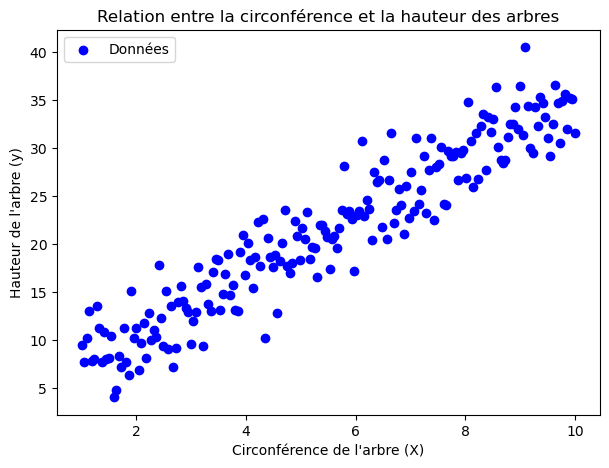

In [68]:
# pour être reproductible, on fixe la seed
np.random.seed(42)

# génération de données synthétiques
n = 200
X = np.linspace(1, 10, n).reshape(-1, 1)
true_slope, true_intercept = 3, 5

# on ajoute un bruit gaussien aux données
# ce bruit correspond à des variations aléatoires (arbres d'essences différentes,
# erreurs de mesure, etc.  )
noise = np.random.normal(0, 3, size=n)
y = true_slope * X.flatten() + true_intercept + noise

# Visualisation des données
plt.figure(figsize=(7, 5))
plt.scatter(X, y, color="blue", label="Données")
plt.xlabel("Circonférence de l'arbre (X)")
plt.ylabel("Hauteur de l'arbre (y)")
plt.title("Relation entre la circonférence et la hauteur des arbres")
plt.legend()
plt.show()

Et on regarde la forme de la fonction de coût.

In [69]:
# grille de paramètres
slope_vals = np.linspace(0, 6, 100)
intercept_vals = np.linspace(2, 8 , 100)
# meshgrid pour avoir tous les couples (slope, intercept)
S, I = np.meshgrid(slope_vals, intercept_vals)

# Calcul vectorié du MSE pour chaque couple (slope, intercept) ---
MSE_vals = np.mean(
        (
            y.reshape(1, 1, -1)
            - (S[:, :, np.newaxis] * X.flatten() + I[:, :, np.newaxis])
        )
        ** 2,
        axis=2,
    )

# Visualisation de la surface de coût
fig = go.Figure(data=[go.Surface(z=MSE_vals, x=slope_vals, y=intercept_vals, colorscale='Viridis'
                                 )],
                )
fig.update_layout(
    title="Fonction de coût (MSE) en fonction des paramètres (a, b)",
    scene=dict(
        xaxis_title="Pente (a)",
        yaxis_title="Ordonnée à l'origine (b)",
        zaxis_title="MSE",
    ),
    autosize=False,
    width=800,
    height=800,
    margin=dict(l=10, r=50, b=65, t=90),
)
fig.show() 

Visiblement, la fonction de coût est convexe : il y a une seule "vallée" et donc un seul minimum global.

Je propose la visualisation suivante pour s'en convaincre : quelle que soit la valeur de a et de b, le [plan tangent](https://www.bibmath.net/dico/index.php?action=affiche&quoi=./p/plantangent.html) à la courbe est toujours en-dessous de la courbe. 


In [70]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def gradient_mse_point(X, y, slope, intercept):
    X_flat = X.flatten()
    y_pred = slope * X_flat + intercept
    error = y_pred - y
    grad_slope = 2 * np.mean(error * X_flat)
    grad_intercept = 2 * np.mean(error)
    return grad_slope, grad_intercept

def tangent_plane(X, y, slope, intercept, S, I):
    mse_at_point = mse(y, slope * X.flatten() + intercept)
    grad_slope, grad_intercept = gradient_mse_point(X, y, slope, intercept)
    Z_tan = mse_at_point + grad_slope * (S - slope) + grad_intercept * (I - intercept)
    return Z_tan


from ipywidgets import interact, FloatSlider

@interact(slope=FloatSlider(min=0, max=6, step=0.1, value=4),
            intercept=FloatSlider(min=2, max=8, step=0.1, value=3))

def plot_tangent_plane(slope, intercept):
    z_tangent = tangent_plane(X, y, slope, intercept, S, I)
    
    fig = go.Figure(data=[
        # point choisi
        go.Scatter3d(x=[slope], y=[intercept], z=[mse(y, slope * X.flatten() + intercept)],
                     mode='markers', marker=dict(size=5, color='red'), name='Point choisi'),
        # surface de coût
        go.Surface(z=MSE_vals, x=slope_vals, y=intercept_vals, colorscale='Viridis', opacity=0.7, name='MSE Surface'),
        go.Surface(z=z_tangent, x=slope_vals, y=intercept_vals, colorscale='Reds', opacity=0.5, name='Tangent Plane')
    ])
    
    fig.update_layout(
        title=f"Plan tangent à la courbe pour pente = {slope}, ordonnée = {intercept})",
        scene=dict(
            xaxis_title="Pente (a)",
            yaxis_title="Ordonnée à l'origine (b)",
            zaxis_title="MSE",
        ),
        autosize=False,
        width=800,
        height=800,
        margin=dict(l=10, r=50, b=65, t=90),
        scene_camera=dict(eye=dict(x=1, y=1.5, z=0.5)),
    )
    fig.show()


interactive(children=(FloatSlider(value=4.0, description='slope', max=6.0), FloatSlider(value=3.0, description…

Plusieurs arguments peuvent être avancés pour montrer cette convexité :

1. Argument graphique : voir graphique ci-dessus.
2. Argument "rapide" : la MSE est une somme de carrés, et les fonctions carrées sont convexes.
3. Argument mathématique : on peut calculer la matrice hessienne de la MSE et montrer qu'elle est définie positive. 

# 1. Résolution analytique

On considère que la MSE est une fonction de deux variables a et b.

C'est une fonction convexe, on peut donc chercher son minimum en annulant son gradient et on est assuré que c'est un minimum global.

$$
\nabla \text{MSE}(a_0, b_0) = 0  \implies (a_0, b_0) = \arg\min_{a, b} \text{MSE}(a, b)
$$



> Le jeu de paramètres (a, b) qui minimise la MSE est donc celui en lequel les dérivées partielles sont nulles.

Graphiquement, cela correspond aux points où la surface de la MSE est la plus basse et les tangentes horizontales.

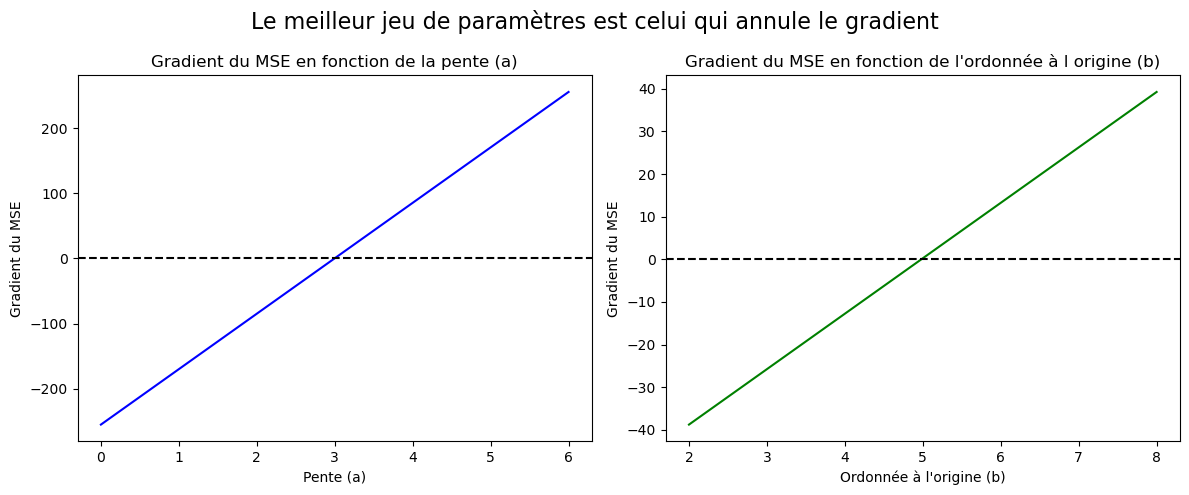

In [71]:
def gradient_mse_vectorized(X, y, slopes, intercepts):
    X_flat = X.flatten()
    n = len(y)
    slopes = slopes[:, np.newaxis]
    intercepts = intercepts[:, np.newaxis]
    y_preds = slopes * X_flat + intercepts
    errors = y_preds - y
    grad_slopes = 2 * np.mean(errors * X_flat, axis=1)
    grad_intercepts = 2 * np.mean(errors, axis=1)
    return grad_slopes, grad_intercepts

grad_slope, grad_intercept = gradient_mse_vectorized(X, y, possible_slopes, possible_intercepts)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

possible_slopes = np.linspace(0, 6, 100)
possible_intercepts = np.linspace(2, 8, 100)

axs[0].plot(possible_slopes, grad_slope, color='blue')
axs[0].axhline(0, color='black', linestyle='--')
axs[0].set_title("Gradient du MSE en fonction de la pente (a)")
axs[0].set_xlabel("Pente (a)")
axs[0].set_ylabel("Gradient du MSE")

axs[1].plot(possible_intercepts, grad_intercept, color='green')
axs[1].axhline(0, color='black', linestyle='--')
axs[1].set_title("Gradient du MSE en fonction de l'ordonnée à l origine (b)")
axs[1].set_xlabel("Ordonnée à l'origine (b)")
axs[1].set_ylabel("Gradient du MSE")

plt.suptitle("Le meilleur jeu de paramètres est celui qui annule le gradient",
             fontsize=16)
plt.tight_layout()

On peut trouver une formule explicite pour a et b en résolvant le système d'équations ci-dessus.

On trouve :

$$
a = \frac{\text{Cov}(X, Y)}{\text{Var}(X)} = \frac{\sum_{i=1}^N (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^N (x_i - \bar{x})^2}\\ \text{et} \\
b = \bar{y} - a \cdot \bar{x}
$$

In [72]:
def analytical_solution(X, y):
    cov_xy = np.sum((X.flatten() - np.mean(X)) * (y - np.mean(y)))
    var_x = np.sum((X.flatten() - np.mean(X)) ** 2)
    a = cov_xy / var_x
    b = np.mean(y) - a * np.mean(X)
    return a, b

print("Résolution analytique :")
a_analytical, b_analytical = analytical_solution(X, y)
print(f" Pente (a) : {a_analytical:.2f}, Ordonnée à l'origine (b) : {b_analytical:.2f}")
print(f"Paramètres réels :\n Pente (a) = {true_slope}, Ordonnée à l'origine (b) = {true_intercept}")

Résolution analytique :
 Pente (a) : 3.08, Ordonnée à l'origine (b) : 4.46
Paramètres réels :
 Pente (a) = 3, Ordonnée à l'origine (b) = 5


Vous remarquerez que les paramètres obtenus par la résolution analytique ne sont pas exactement les mêmes que les "vrais" paramètres utilisés pour générer les données. C'est normal, car les données sont bruitées.

Pour vous en convaincre : 

In [73]:
y_without_noise = true_slope * X.flatten() + true_intercept

print("Résolution analytique :")
a_analytical, b_analytical = analytical_solution(X, y_without_noise)
print(f" Pente (a) : {a_analytical:.2f}, Ordonnée à l'origine (b) : {b_analytical:.2f}")
print(f"Paramètres réels :\n Pente (a) = {true_slope}, Ordonnée à l'origine (b) = {true_intercept}")

Résolution analytique :
 Pente (a) : 3.00, Ordonnée à l'origine (b) : 5.00
Paramètres réels :
 Pente (a) = 3, Ordonnée à l'origine (b) = 5


# 2. Résolution algébrique

On note X la matrice des entrées augmentée d'une colonne de 1 (pour le biais), Y le vecteur des sorties et beta le vecteur des paramètres (a, b).

$$
X = \begin{bmatrix} 1 & x_1 \\ 1 & x_2 \\ \vdots & \vdots \\ 1 & x_n \end{bmatrix}, \quad
Y = \begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{bmatrix}, \quad
\beta = \begin{bmatrix} b \\ a \end{bmatrix}, \quad
\hat{Y} = X \cdot \beta
$$


Si on note E = Y - Ŷ, on a :
$$
\text{MSE}(\beta) = \frac{1}{n} \, \| E \|^2 = \frac{1}{n} \, \| Y - X\beta \|^2
$$

E représente le vecteur des erreurs entre les vraies valeurs et les valeurs prédites par le modèle, intuitivement on cherche à ce que ce vecteur soit le plus petit possible, c'est-à-dire à minimiser sa norme.

Le problème s'écrit alors : 

$$
\min_{\beta} \frac{1}{n} \, \| Y - X\beta \|^2  
$$

On peut alors prouver que, si X est injective (c'est à dire *full rank*), le meilleur beta qui minimise la MSE est donné par la formule des moindres carrés ordinaires (OLS) :
$$
\beta = (X^T \cdot X)^{-1} \cdot X
^T \cdot Y
$$

Le XB en question est la projection orthogonale de Y sur l'espace engendré par les colonnes de X.

Pour avoir une intuition de ce qui se passe on peut regarder la figure ci-dessous.

In [95]:
def algebraic_solution(X, y): 
    n = X.shape[0]
    # ajout de la colonne d'intercept
    X = np.vstack([np.ones(n), X.flatten()]).T
    return np.linalg.inv(X.T @ X) @ X.T @ y

print("Résolution algébrique :")
sol = algebraic_solution(X, y)
print(f" Pente (a) : {sol[1]:.2f}, Ordonnée à l'origine (b) : {sol[0]:.2f}")
print(f"Paramètres réels :\n Pente (a) = {true_slope}, Ordonnée à l'origine (b) = {true_intercept}")

Résolution algébrique :
 Pente (a) : 3.08, Ordonnée à l'origine (b) : 4.46
Paramètres réels :
 Pente (a) = 3, Ordonnée à l'origine (b) = 5


<p align="center">
  <img src="./img/proj_ortho.png" alt="plot" width="50%"/>
</p>

# 3. Comparaison des deux méthodes

| Critère                  | Analytique                                | Algébrique / Numérique                     |
|---------------------------|-------------------------------------------|-------------------------------------------|
| Solution exacte           | ✓                                         | ✗ (approchée)                             |
| Rapidité                  | ✓ rapide pour petits systèmes             | ✗ plus lent, surtout grands systèmes      |
| Complexité du problème    | ✗ difficile si système complexe           | ✓ gère systèmes grands ou non-linéaires   |
| Interprétation            | ✓ facile à interpréter                     | ✗ moins intuitive                          |
| Flexibilité               | ✗ peu flexible                             | ✓ très flexible (contraintes, régularisation) |
| Sensibilité aux erreurs   | ✗ sensible aux arrondis                    | ✓ moins sensible                            |


> Nous verrons au cours suivant une troisième méthode de résolution, la plus utilisée en pratique : **la descente de gradient**.